Source: https://www.tensorflow.org/tutorials/keras/text_classification

In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses

An example of what the path join does.

In [3]:
path = "/home"
print(os.path.join(path, "User/Desktop", "file.txt"))

/home/User/Desktop/file.txt


In [4]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [5]:
print(dataset_dir)

./aclImdb


In the next line we, access the dataset_dir and list its items.

In [6]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [7]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

text_dataset_from_directory requires a directory to be of the shape: 
<br>
<br>

main_directory/
<br>
...class_a/
<br>
......a_text_1.txt
<br>
......a_text_2.txt
<br>
...class_b/
<br>
......b_text_1.txt
<br>
......b_text_2.txt

<br>
<br>

In the next line, we will delete an extraneous folder.

In [8]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [9]:
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

text_dataset_from_directory returns a tf.data.Dataset object. 

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset="training",
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
print(type(raw_train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset="validation",
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
"aclImdb/test",
batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)


2022-07-15 15:00:24.756078: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label


In [18]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))


Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

>The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

>The Dense layer is just your regular densely-connected NN layer. The integer is the dimension of the output.

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

This is the training of the model. 

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6631 - binary_accuracy: 0.6913 - val_loss: 0.6125 - val_binary_accuracy: 0.7710
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5465 - binary_accuracy: 0.8014 - val_loss: 0.4964 - val_binary_accuracy: 0.8220
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4426 - binary_accuracy: 0.8447 - val_loss: 0.4189 - val_binary_accuracy: 0.8454
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3773 - binary_accuracy: 0.8656 - val_loss: 0.3731 - val_binary_accuracy: 0.8610
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3354 - binary_accuracy: 0.8782 - val_loss: 0.3446 - val_binary_accuracy: 0.8666
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3042 - binary_accuracy: 0.8889 - val_loss: 0.3254 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3103 - binary_accuracy: 0.8736
Loss:  0.31025928258895874
Accuracy:  0.8735600113868713


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

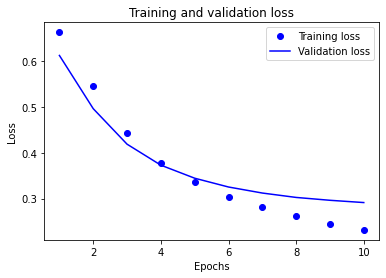

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

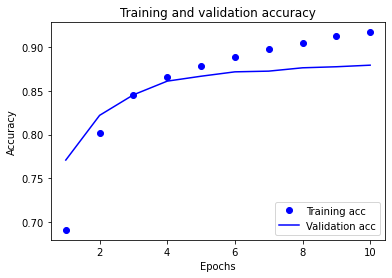

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [34]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 1s 1ms/step - loss: 0.3103 - accuracy: 0.8736
0.8735600113868713


In [35]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
    "I loved the movie.",
    "The movie was a disgrace.",
    "It was definitely a movie.",
    "It was a movie.",
    "I have seen many movies, and this was one of them."
]

export_model.predict(examples)

array([[0.6405605 ],
       [0.46473104],
       [0.3801084 ],
       [0.6506124 ],
       [0.4697609 ],
       [0.6273695 ],
       [0.54842824],
       [0.59098065]], dtype=float32)